<a href="https://colab.research.google.com/github/BenAbramowitz/BenAbramowitz.github.io/blob/main/WeightingExperts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We have a set of "experts" who each have (1) an independent competence representing the probability that they will vote correctly on a binary issue, and (2) a weight.


The experts vote on the issue using a weighted majority rule.


The way the experts get these weights is by delegation from a body of voters 


The voters only assign weights to the representatives. They don't provide any other information. For simplicity, the only rule we consider for aggregating the weights is summing them, or equivalently, averaging them.


The purpose of these simulations is to explore the different ways in which voters might assign weights to the representatives, and compare their performance to the optimal weighted majority rule.

A profile consists of:


*   A set of experts with (1) a competence, (2) a weight, and (3) a vote drawn using their competence
*   A set of voters where each voter has a weight for each representative







In [3]:
### Standard Magic and startup initializers.

import math
import csv
import numpy as np
import scipy.stats as stats
#import random
#import itertools
#import time
#import nbconvert
#from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

#from collections import Counter
#from multiprocessing import Pool

#Importing iPython Notebooks
# import nbimporter
# import Generate_Preferences as GenPref
# import Run_Election as Elect

_DEBUG = False

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

font = {'size'   : 22}

matplotlib.rc('font', **font)

# Pretty print a dict...
def pp_dict(kname, vname, d):
    o = ""
    # Object Headder
    o += "{:^15}".format(kname) + "|" + "{:^35}".format(vname) + "\n"
    o += "{:-^50}".format("") + "\n"
    for k,v in sorted(d.items()):
        o += "{:^15}".format(str(k)) + "|" + "{:^35}".format(str(v)) + "\n"
    print(o)

In [4]:
class Profile:

  def __init__(self, num_experts, num_voters, default_distribution=None):
    self.num_experts = num_experts
    self.num_voters = num_voters
    self.expert_competences = [0.5]*num_experts
    self.expert_weights = [1]*num_experts
    self.expert_votes = []
    self.outcome = None #Binary: 0 or 1 where 1 is correct

    self.delegations = {}
    if(default_distribution is None):
      for i in range(num_voters):
        self.delegations[i] = [0]*num_experts
    elif(default_distribution is "uniform"):
      for i in range(num_voters):
        self.delegations[i] = [1]*num_experts
    else:
      print("Invalid default distribution")


  #GETTERS
  def get_num_experts(self):
    #print(self.num_experts)
    return self.num_experts

  def get_num_voters(self):
    #print(self.num_voters)
    return self.num_voters

  def get_expert_competences(self):
    #print(self.expert_competences)
    return self.expert_competences

  def get_expert_weights(self):
    #print(self.expert_weights)
    return self.expert_weights

  def get_expert_votes(self):
    #print(self.expert_votes)
    return self.expert_votes

  def get_outcome(self):
    #print(self.outcome)
    return self.outcome

  def get_delegations(self):
    #print(self.delegations)
    return self.delegations


  #SETTERS
  def set_num_experts(self, num):
    self.num_experts = num

  def set_num_voters(self, num):
    self.num_voters = num

  def set_expert_competences(self, competences=None):
    if(len(competences) != self.num_experts):
      print("Number of competences given does not match number of experts")
      return -1
    else:
      self.expert_competences = competences
      

  def set_expert_weights(self, weights):
    if(len(weights) != self.num_experts):
      print("Number of weights given does not match number of experts")
      return -1
    self.expert_weights = weights

  def set_optimal_expert_weights(self):
    self.expert_weights = [np.log(p/(1-p)) for p in self.expert_competences]

  # def set_delegations(self, delegations_dict):
  #   self.delegations = delegations_dict

  def set_delegations_single_pair(self, voter, expert, delegation):
    self.delegations[voter][expert] = delegation


  #SCALE THE WEIGHTS OF EXPERTS BY A MULTIPLICATIVE FACTOR
  def scale_expert_weights(self, scale):
    self.expert_weights = self.expert_weights * scale


  #ONE PERSON - ONE VOTE
  def normalize_delegations(self):
    for i in range(self.num_voters):
      if(max(self.delegations[i]) != 0):
        self.delegations[i] = self.delegations[i] / sum(self.delegations[i])

  #BOUND WEIGHTS
  # def normalize_delegations(self):
  #   for i in range(self.num_voters):
  #     if(max(self.delegations[i]) != 0):
  #       self.delegations[i] = self.delegations[i] / max(self.delegations[i])


  #DETERMINE WEIGHTS OF EXPERTS BY SUMMING DELEGATED WEIGHTS FROM VOTERS
  def sum_delegations(self):
    for i in range(self.num_experts):
      self.expert_weights[i] = 0
      for j in range(self.num_voters):
        self.expert_weights[i] = self.expert_weights[i] + self.delegations[j][i]


  #GENERATE VOTES OF EXPERTS BASED ON THEIR COMPETENCES
  def generate_expert_votes(self):
    self.expert_votes = [0]*self.num_experts
    for expert in range(self.num_experts):
      self.expert_votes[expert] = int(np.random.rand() < self.expert_competences[expert])


  #CONDUCT A WEIGHTED MAJORITY VOTE BY EXPERTS TO DETERMINE OUTCOME IN {0,1}
  def weighted_majority_vote(self):
    if(self.expert_weights is None or self.expert_votes == []):
      print("Invalid expert weights or votes ")
      return -1
    total_weight = sum(self.expert_weights)
    correct_weight = np.inner(self.expert_weights, self.expert_votes)
    if(correct_weight / total_weight > 0.5):
      self.outcome = 1
    else:
      self.outcome = 0

In [177]:
#GENERATES NUM_EXPERTS SAMPLES FROM A TRUNCATED NORMAL DISTRIBUTION  IN [LOWER, UPPER]
#THIS IS FOR GENERATING EXPERT COMPETENCES AND VOTER ESTIMATES OF EXPERT COMPETENCES
lower = 0.01
upper = 0.99
num_samples = 10
mu = 0.6 #mean
sigma = 0 #standard deviation
def generate_gaussian_competences(mu = 0.6, sigma = 0.3, num_samples=5, *args, **kwargs):
  if(sigma == 0):
    gaussian_samples = np.random.normal(mu, sigma, num_samples)
  else:
    gaussian_samples = stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma, loc=mu, scale=sigma, size=num_samples)
  return gaussian_samples


# print(generate_gaussian_competences(mu, sigma, num_samples))

#FIRST EXPERIMENT
Draw the expert competences from different Gaussian distributions by varying the mean or variance and compare the accuracy of the Bayesian optimal weighted majority rules that result.

Keep num experts constant at 5 and num voters expert at 100

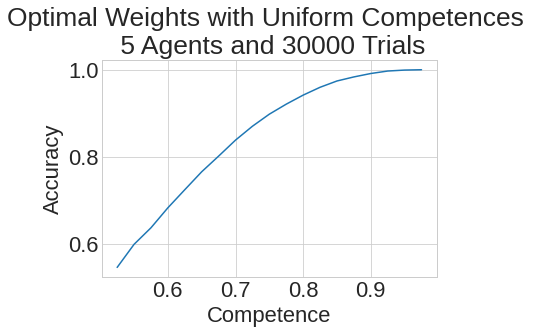

<Figure size 432x288 with 0 Axes>

In [180]:
NUM_VOTERS = 100
NUM_EXPERTS = 5
NUM_TRIALS = 30000 #20,000


means = np.arange(0.525, 1.0, 0.025)
variances = np.arange(0, 0.55, 0.05)


accuracies = []
for mean in means:
  num_correct = 0
  profile = Profile(NUM_EXPERTS, NUM_VOTERS)
  for i in range(NUM_TRIALS):
    competences = generate_gaussian_competences(mean, 0, NUM_EXPERTS)
    profile.set_expert_competences(competences)
    profile.set_optimal_expert_weights()
    profile.generate_expert_votes()
    profile.weighted_majority_vote()
    if(profile.get_outcome() == 1):
      num_correct = num_correct + 1
  accuracies.append(num_correct / NUM_TRIALS)

# print(accuracies)
plt.xlabel("Competence")
plt.ylabel("Accuracy")
plt.title("Optimal Weights with Uniform Competences \n {} Agents and {} Trials".format(NUM_EXPERTS, NUM_TRIALS))
plt.plot(means, accuracies)
plt.show()
plt.savefig('uniform_competences_5agents_30000trials.png')





[0.9126, 0.92476, 0.93038, 0.93386, 0.93486, 0.93718, 0.93608, 0.93714, 0.93772]


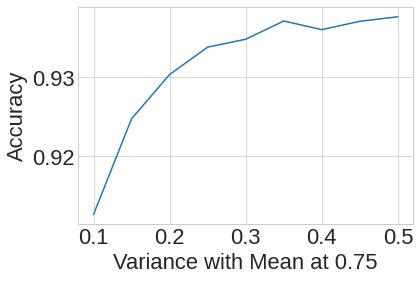

In [ ]:
NUM_VOTERS = 100
NUM_EXPERTS = 5
NUM_TRIALS = 50000 #50,000
#Need like 100,000 iterations to make the curve smooth. 
#50,000 took 2 min without parallelization


means = np.arange(0.5, 1.05, 0.025)
variances = np.arange(0.1, 0.55, 0.05)


accuracies = []
for variance in variances:
  num_correct = 0
  profile = Profile(NUM_EXPERTS, NUM_VOTERS)
  for i in range(NUM_TRIALS):
    competences = generate_gaussian_competences(0.75, variance, NUM_EXPERTS)
    profile.set_expert_competences(competences)
    profile.set_optimal_expert_weights()
    profile.generate_expert_votes()
    profile.weighted_majority_vote()
    if(profile.get_outcome() == 1):
      num_correct = num_correct + 1
  accuracies.append(num_correct / NUM_TRIALS)

print(accuracies)
plt.xlabel("Variance with Mean at 0.75")
plt.ylabel("Accuracy")
plt.plot(variances, accuracies)
plt.show()

#SECOND AND THIRD EXPERIMENT
Assume that voter estimates of expert competences are drawn from Gaussian distribution with mean equal to their true competence, and look at accuracy of the weighting when voters assign what they believe to be the optimal weights.

Next, do the same thing, but normalize the weights before they are summed up

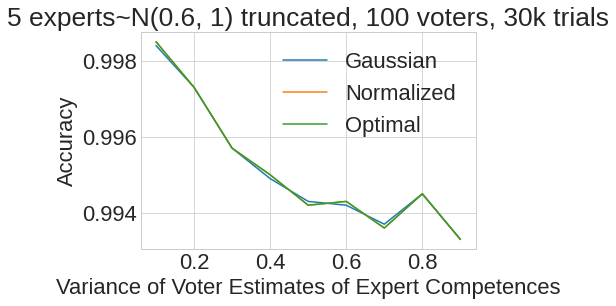

In [ ]:
NUM_VOTERS = 500
NUM_EXPERTS = 20
NUM_TRIALS = 10000

competence_mean = 0.6
competence_variance = 1
estimate_variances = np.arange(0.1, 1, 0.1)


accuracies_gaussian_estimates = []
accuracies_gaussian_normalized = []
accuracies_optimal_weights = []

for ev in estimate_variances:

  num_correct_gaussian_estimates = 0
  num_correct_gaussian_normalized = 0
  num_correct_optimal_weights = 0
  profile = Profile(NUM_EXPERTS, NUM_VOTERS)

  for i in range(NUM_TRIALS):
    competences = generate_gaussian_competences(competence_mean, competence_variance, profile.get_num_experts())
    profile.set_expert_competences(competences)
    for x in range(NUM_EXPERTS):
      competence_estimates = generate_gaussian_competences(competences[x], ev, profile.get_num_voters())
      delegated_weights = np.log(competence_estimates / (1 - competence_estimates))
      for v in range(profile.get_num_voters()):
        profile.set_delegations_single_pair(v, x, delegated_weights[v])

    profile.generate_expert_votes()


    profile.sum_delegations()
    profile.weighted_majority_vote()
    if(profile.get_outcome() == 1):
      num_correct_gaussian_estimates = num_correct_gaussian_estimates + 1
    

    profile.normalize_delegations()
    profile.sum_delegations()
    profile.weighted_majority_vote()
    if(profile.get_outcome() == 1):
      num_correct_gaussian_normalized = num_correct_gaussian_normalized + 1
    

    profile.set_optimal_expert_weights()
    profile.weighted_majority_vote()
    if(profile.get_outcome() == 1):
      num_correct_optimal_weights = num_correct_optimal_weights + 1


  accuracies_gaussian_estimates.append(num_correct_gaussian_estimates / NUM_TRIALS)
  accuracies_gaussian_normalized.append(num_correct_gaussian_normalized / NUM_TRIALS)
  accuracies_optimal_weights.append(num_correct_gaussian_normalized / NUM_TRIALS)


plt.xlabel("Variance of Voter Estimates of Expert Competences")
plt.ylabel("Accuracy")
plt.plot(estimate_variances, accuracies_gaussian_estimates)
plt.plot(estimate_variances, accuracies_gaussian_normalized)
plt.plot(estimate_variances, accuracies_optimal_weights)
plt.legend(["Gaussian", "Normalized", "Optimal"])
plt.title("20 experts~N(0.6, 1) truncated, 500 voters, 10k trials")
plt.show()





In [152]:
#TESTING AREA

#np.random.seed(11221993)

profile = Profile(20, 100)

num_correct = 0
num_trials = 1
for i in range(num_trials):
  competences = generate_gaussian_competences(0.55, 0.0001, 20)
  print(competences)
  profile.set_expert_competences(competences)
  print(profile.get_expert_competences())
#profile.get_expert_competences()
  profile.set_optimal_expert_weights()
  print(profile.get_expert_weights())
#profile.get_expert_weights()
  profile.generate_expert_votes()
  print(profile.get_expert_votes())
  profile.weighted_majority_vote()
  if(profile.get_outcome() == 1):
    num_correct = num_correct + 1

print(num_correct / num_trials)

print(np.dot(profile.get_expert_votes(), profile.get_expert_weights()))
print(np.sum(profile.get_expert_weights()))



[0.5500965  0.55007495 0.54998066 0.54979353 0.54988811 0.5501594
 0.55007274 0.54982618 0.55015952 0.55005468 0.55000873 0.54997213
 0.55019642 0.55008784 0.5500678  0.55006152 0.55020031 0.54994273
 0.5499922  0.54994259]
[0.5500965  0.55007495 0.54998066 0.54979353 0.54988811 0.5501594
 0.55007274 0.54982618 0.55015952 0.55005468 0.55000873 0.54997213
 0.55019642 0.55008784 0.5500678  0.55006152 0.55020031 0.54994273
 0.5499922  0.54994259]
[0.20106060199218742, 0.20097354744342644, 0.20059255546923113, 0.19983651663251706, 0.200218638650116, 0.20131477008782908, 0.20096458395852848, 0.19996840814260547, 0.2013152516221068, 0.20089164151163155, 0.20070597047865846, 0.20055807143044146, 0.2014643380654235, 0.20102562651007408, 0.20094462406075647, 0.2009192756267389, 0.2014800527226037, 0.20043930362524484, 0.2006391890350754, 0.20043873637843826]
[0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]
1.0
2.4109035628081505
4.015751703443635
